# Models Comparison for TinyML

In [50]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [51]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 2

In [52]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [53]:
n_labels = 2 + taskIndex
samples = 30
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [54]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [55]:
y = np.array([int(el) for el in y])
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(24, 42)
(24,)


In [57]:
y_test

array([2, 2, 2, 3, 1, 0, 1, 0, 1, 2, 3, 3, 0, 1, 3, 2, 2, 1, 0, 0, 1, 3,
       0, 3])

## Model Spotting

In [9]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [11]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))
"""
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))
                                                          """


"\nif n_labels == 5:\n    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, \n                                                           max_features=9, criterion='entropy', max_depth=None,\n                                                           min_samples_split=4, min_samples_leaf=1\n                                                          )))\n\nelse:\n    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, \n                                                           max_features=5, criterion='gini', max_depth=None,\n                                                           min_samples_split=4, min_samples_leaf=1\n                                                          )))\n                                                          "

In [12]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,40 0,08
LR - 0,61 0,04
CART - 0,66 0,10
SVC - 0,68 0,05
RF - 0,73 0,07


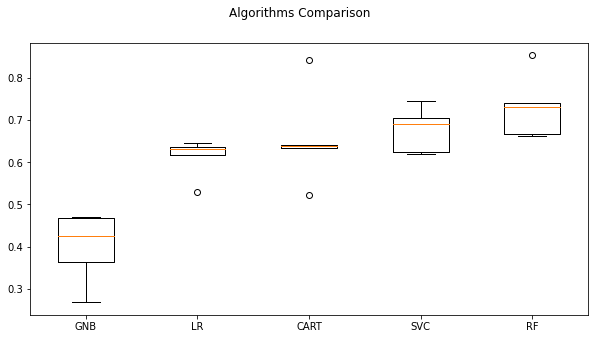

In [13]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [14]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.17      0.25         6
           2       0.67      0.33      0.44         6
           3       0.29      0.67      0.40         6

    accuracy                           0.46        24
   macro avg       0.56      0.46      0.46        24
weighted avg       0.56      0.46      0.46        24

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.57      0.67      0.62         6
           2       0.33      0.17      0.22         6
           3       0.80      0.67      0.73         6

    accuracy                           0.58        24
   macro avg       0.57      0.58      0.56        24
weighted avg       0.57      0.58      0.56        24

---------------------------------------------

# Neural Network

In [45]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 512
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [46]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_28 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 693us/step - loss: 1.3938 - accuracy: 0.2500
Epoch 2/500
11

11/11 [==============================] - 0s 704us/step - loss: 0.0522 - accuracy: 1.0000
Epoch 72/500
11/11 [==============================] - 0s 796us/step - loss: 0.0852 - accuracy: 1.0000
Epoch 73/500
11/11 [==============================] - 0s 645us/step - loss: 0.1422 - accuracy: 0.9474
Epoch 74/500
11/11 [==============================] - 0s 703us/step - loss: 0.0805 - accuracy: 0.9605
Epoch 75/500
11/11 [==============================] - 0s 793us/step - loss: 0.0756 - accuracy: 0.9868
Epoch 76/500
11/11 [==============================] - 0s 653us/step - loss: 0.0639 - accuracy: 0.9868
Epoch 77/500
11/11 [==============================] - 0s 791us/step - loss: 0.0431 - accuracy: 1.0000
Epoch 78/500
11/11 [==============================] - 0s 628us/step - loss: 0.0487 - accuracy: 1.0000
Epoch 79/500
11/11 [==============================] - 0s 664us/step - loss: 0.0677 - accuracy: 1.0000
Epoch 80/500
11/11 [==============================] - 0s 797us/step - loss: 0.0470 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 813us/step - loss: 0.0169 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 624us/step - loss: 0.0164 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 867us/step - loss: 0.0131 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 832us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 155/500
11/11 [==============================] - 0s 621us/step - loss: 0.0161 - accuracy: 1.0000
Epoch 156/500
11/11 [==============================] - 0s 854us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 157/500
11/11 [==============================] - 0s 647us/step - loss: 0.0182 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 800us/step - loss: 0.0094 - accuracy: 1.0000
Epoch 159/500
11/11 [==============================] - 0s 792us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 160/500
11/11 [==============================] - 0s 659us/step - lo

11/11 [==============================] - 0s 731us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 731us/step - loss: 0.0088 - accuracy: 1.0000
Epoch 232/500
11/11 [==============================] - 0s 709us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 717us/step - loss: 0.0068 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 786us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 761us/step - loss: 0.0080 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 706us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 237/500
11/11 [==============================] - 0s 784us/step - loss: 0.0106 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 734us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 239/500
11/11 [==============================] - 0s 619us/step - loss: 0.0055 - a

11/11 [==============================] - 0s 694us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 310/500
11/11 [==============================] - 0s 808us/step - loss: 0.0027 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 773us/step - loss: 0.0096 - accuracy: 1.0000
Epoch 312/500
11/11 [==============================] - 0s 616us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 761us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 314/500
11/11 [==============================] - 0s 673us/step - loss: 0.0167 - accuracy: 1.0000
Epoch 315/500
11/11 [==============================] - 0s 738us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 737us/step - loss: 0.0510 - accuracy: 0.9737
Epoch 317/500
11/11 [==============================] - 0s 645us/step - loss: 0.0110 - accuracy: 0.9868
Epoch 318/500
11/11 [==============================] - 0s 734us/step - loss: 0.0274 - a

11/11 [==============================] - 0s 693us/step - loss: 0.0358 - accuracy: 0.9868
Epoch 389/500
11/11 [==============================] - 0s 870us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 666us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 834us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 392/500
11/11 [==============================] - 0s 761us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 393/500
11/11 [==============================] - 0s 667us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 857us/step - loss: 0.0318 - accuracy: 0.9868
Epoch 395/500
11/11 [==============================] - 0s 741us/step - loss: 0.0184 - accuracy: 0.9868
Epoch 396/500
11/11 [==============================] - 0s 647us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 397/500
11/11 [==============================] - 0s 821us/step - loss: 0.0401 - a

11/11 [==============================] - 0s 781us/step - loss: 9.8753e-04 - accuracy: 1.0000
Epoch 468/500
11/11 [==============================] - 0s 745us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 683us/step - loss: 6.3337e-04 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 682us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 782us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 472/500
11/11 [==============================] - 0s 753us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 766us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 800us/step - loss: 5.7322e-04 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 639us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 476/500
11/11 [==============================] - 0s 799us/step - loss

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_30 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_31 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 689us/step - loss: 1.3940 - accuracy: 0.2597
Epoch 2/500
11

11/11 [==============================] - 0s 759us/step - loss: 0.0801 - accuracy: 0.9740
Epoch 72/500
11/11 [==============================] - 0s 692us/step - loss: 0.0812 - accuracy: 0.9610
Epoch 73/500
11/11 [==============================] - 0s 832us/step - loss: 0.0802 - accuracy: 0.9740
Epoch 74/500
11/11 [==============================] - 0s 660us/step - loss: 0.1244 - accuracy: 0.9610
Epoch 75/500
11/11 [==============================] - 0s 699us/step - loss: 0.0526 - accuracy: 0.9870
Epoch 76/500
11/11 [==============================] - 0s 715us/step - loss: 0.0519 - accuracy: 1.0000
Epoch 77/500
11/11 [==============================] - 0s 633us/step - loss: 0.0368 - accuracy: 1.0000
Epoch 78/500
11/11 [==============================] - 0s 722us/step - loss: 0.0727 - accuracy: 0.9870
Epoch 79/500
11/11 [==============================] - 0s 582us/step - loss: 0.0668 - accuracy: 0.9870
Epoch 80/500
11/11 [==============================] - 0s 690us/step - loss: 0.0726 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 803us/step - loss: 0.0232 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 665us/step - loss: 0.0172 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 701us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 706us/step - loss: 0.0175 - accuracy: 0.9870
Epoch 155/500
11/11 [==============================] - 0s 631us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 156/500
11/11 [==============================] - 0s 789us/step - loss: 0.0157 - accuracy: 1.0000
Epoch 157/500
11/11 [==============================] - 0s 630us/step - loss: 0.0190 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 673us/step - loss: 0.0184 - accuracy: 0.9870
Epoch 159/500
11/11 [==============================] - 0s 793us/step - loss: 0.0194 - accuracy: 1.0000
Epoch 160/500
11/11 [==============================] - 0s 601us/step - lo

11/11 [==============================] - 0s 707us/step - loss: 0.0092 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 716us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 232/500
11/11 [==============================] - 0s 700us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 627us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 646us/step - loss: 0.0117 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 681us/step - loss: 0.0200 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 653us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 237/500
11/11 [==============================] - 0s 747us/step - loss: 0.0142 - accuracy: 0.9870
Epoch 238/500
11/11 [==============================] - 0s 672us/step - loss: 0.0076 - accuracy: 1.0000
Epoch 239/500
11/11 [==============================] - 0s 697us/step - loss: 0.0038 - a

11/11 [==============================] - 0s 513us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 310/500
11/11 [==============================] - 0s 556us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 568us/step - loss: 0.0133 - accuracy: 0.9870
Epoch 312/500
11/11 [==============================] - 0s 539us/step - loss: 0.0126 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 518us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 314/500
11/11 [==============================] - 0s 517us/step - loss: 0.0216 - accuracy: 1.0000
Epoch 315/500
11/11 [==============================] - 0s 702us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 551us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 317/500
11/11 [==============================] - 0s 551us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 318/500
11/11 [==============================] - 0s 521us/step - loss: 0.0050 - a

11/11 [==============================] - 0s 619us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 609us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 579us/step - loss: 0.0160 - accuracy: 0.9870
Epoch 391/500
11/11 [==============================] - 0s 673us/step - loss: 0.0551 - accuracy: 0.9870
Epoch 392/500
11/11 [==============================] - 0s 570us/step - loss: 0.0546 - accuracy: 0.9740
Epoch 393/500
11/11 [==============================] - 0s 619us/step - loss: 0.0148 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 570us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 395/500
11/11 [==============================] - 0s 610us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 396/500
11/11 [==============================] - 0s 543us/step - loss: 0.0131 - accuracy: 1.0000
Epoch 397/500
11/11 [==============================] - 0s 597us/step - loss: 0.0024 - a

11/11 [==============================] - 0s 501us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 468/500
11/11 [==============================] - 0s 546us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 522us/step - loss: 0.0159 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 554us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 567us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 472/500
11/11 [==============================] - 0s 515us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 531us/step - loss: 8.5057e-04 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 512us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 513us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 476/500
11/11 [==============================] - 0s 532us/step - loss: 0.0072

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_32 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_33 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 659us/step - loss: 1.3792 - accuracy: 0.2338
Epoch 2/500
11

11/11 [==============================] - 0s 620us/step - loss: 0.1474 - accuracy: 0.9610
Epoch 72/500
11/11 [==============================] - 0s 652us/step - loss: 0.0627 - accuracy: 0.9870
Epoch 73/500
11/11 [==============================] - 0s 576us/step - loss: 0.0778 - accuracy: 0.9870
Epoch 74/500
11/11 [==============================] - 0s 601us/step - loss: 0.0805 - accuracy: 0.9740
Epoch 75/500
11/11 [==============================] - 0s 575us/step - loss: 0.0587 - accuracy: 0.9870
Epoch 76/500
11/11 [==============================] - 0s 548us/step - loss: 0.0595 - accuracy: 0.9870
Epoch 77/500
11/11 [==============================] - 0s 501us/step - loss: 0.1081 - accuracy: 0.9481
Epoch 78/500
11/11 [==============================] - 0s 515us/step - loss: 0.0743 - accuracy: 0.9870
Epoch 79/500
11/11 [==============================] - 0s 563us/step - loss: 0.0676 - accuracy: 0.9740
Epoch 80/500
11/11 [==============================] - 0s 524us/step - loss: 0.0510 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 515us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 545us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 530us/step - loss: 0.0193 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 489us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 155/500
11/11 [==============================] - 0s 521us/step - loss: 0.0296 - accuracy: 0.9870
Epoch 156/500
11/11 [==============================] - 0s 557us/step - loss: 0.0414 - accuracy: 0.9870
Epoch 157/500
11/11 [==============================] - 0s 525us/step - loss: 0.0288 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 512us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 159/500
11/11 [==============================] - 0s 511us/step - loss: 0.0110 - accuracy: 1.0000
Epoch 160/500
11/11 [==============================] - 0s 530us/step - lo

11/11 [==============================] - 0s 525us/step - loss: 0.0216 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 512us/step - loss: 0.0197 - accuracy: 0.9870
Epoch 232/500
11/11 [==============================] - 0s 511us/step - loss: 0.0105 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 521us/step - loss: 0.0114 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 501us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 516us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 544us/step - loss: 0.0037 - accuracy: 1.0000
Epoch 237/500
11/11 [==============================] - 0s 520us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 527us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 239/500
11/11 [==============================] - 0s 531us/step - loss: 0.0084 - a

11/11 [==============================] - 0s 555us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 310/500
11/11 [==============================] - 0s 596us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 516us/step - loss: 0.0190 - accuracy: 1.0000
Epoch 312/500
11/11 [==============================] - 0s 501us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 493us/step - loss: 0.0179 - accuracy: 0.9870
Epoch 314/500
11/11 [==============================] - 0s 492us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 315/500
11/11 [==============================] - 0s 480us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 486us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 317/500
11/11 [==============================] - 0s 529us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 318/500
11/11 [==============================] - 0s 508us/step - loss: 0.0014 - a

11/11 [==============================] - 0s 553us/step - loss: 0.0106 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 522us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 531us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 540us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 392/500
11/11 [==============================] - 0s 507us/step - loss: 0.0099 - accuracy: 1.0000
Epoch 393/500
11/11 [==============================] - 0s 514us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 527us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 395/500
11/11 [==============================] - 0s 520us/step - loss: 0.0159 - accuracy: 0.9870
Epoch 396/500
11/11 [==============================] - 0s 532us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 397/500
11/11 [==============================] - 0s 521us/step - loss: 0.0134 - a

11/11 [==============================] - 0s 490us/step - loss: 0.0111 - accuracy: 1.0000
Epoch 468/500
11/11 [==============================] - 0s 512us/step - loss: 6.7895e-04 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 505us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 498us/step - loss: 3.4787e-04 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 518us/step - loss: 7.6961e-04 - accuracy: 1.0000
Epoch 472/500
11/11 [==============================] - 0s 593us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 619us/step - loss: 0.0010 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 504us/step - loss: 0.0122 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 500us/step - loss: 6.3672e-04 - accuracy: 1.0000
Epoch 476/500
11/11 [==============================] - 0s 484us/step - 

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_34 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 642us/step - loss: 1.3930 - accuracy: 0.1948
Epoch 2/500
11

11/11 [==============================] - 0s 506us/step - loss: 0.0549 - accuracy: 0.9870
Epoch 72/500
11/11 [==============================] - 0s 642us/step - loss: 0.0850 - accuracy: 0.9870
Epoch 73/500
11/11 [==============================] - 0s 540us/step - loss: 0.0896 - accuracy: 0.9610
Epoch 74/500
11/11 [==============================] - 0s 527us/step - loss: 0.0746 - accuracy: 0.9870
Epoch 75/500
11/11 [==============================] - 0s 545us/step - loss: 0.0912 - accuracy: 0.9740
Epoch 76/500
11/11 [==============================] - 0s 523us/step - loss: 0.0533 - accuracy: 1.0000
Epoch 77/500
11/11 [==============================] - 0s 536us/step - loss: 0.0972 - accuracy: 0.9610
Epoch 78/500
11/11 [==============================] - 0s 520us/step - loss: 0.0917 - accuracy: 0.9740
Epoch 79/500
11/11 [==============================] - 0s 513us/step - loss: 0.0540 - accuracy: 1.0000
Epoch 80/500
11/11 [==============================] - 0s 500us/step - loss: 0.0442 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 529us/step - loss: 0.0164 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 526us/step - loss: 0.0176 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 516us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 514us/step - loss: 0.0490 - accuracy: 0.9870
Epoch 155/500
11/11 [==============================] - 0s 517us/step - loss: 0.0149 - accuracy: 1.0000
Epoch 156/500
11/11 [==============================] - 0s 517us/step - loss: 0.0251 - accuracy: 0.9870
Epoch 157/500
11/11 [==============================] - 0s 495us/step - loss: 0.0084 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 512us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 159/500
11/11 [==============================] - 0s 494us/step - loss: 0.0208 - accuracy: 0.9870
Epoch 160/500
11/11 [==============================] - 0s 549us/step - lo

11/11 [==============================] - 0s 616us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 558us/step - loss: 0.0130 - accuracy: 1.0000
Epoch 232/500
11/11 [==============================] - 0s 536us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 542us/step - loss: 0.0152 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 510us/step - loss: 0.0243 - accuracy: 0.9870
Epoch 235/500
11/11 [==============================] - 0s 548us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 508us/step - loss: 0.1045 - accuracy: 0.9740
Epoch 237/500
11/11 [==============================] - 0s 516us/step - loss: 0.0158 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 534us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 239/500
11/11 [==============================] - 0s 506us/step - loss: 0.0109 - a

11/11 [==============================] - 0s 634us/step - loss: 0.0822 - accuracy: 0.9870
Epoch 310/500
11/11 [==============================] - 0s 560us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 592us/step - loss: 0.0123 - accuracy: 1.0000
Epoch 312/500
11/11 [==============================] - 0s 615us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 578us/step - loss: 0.0376 - accuracy: 0.9870
Epoch 314/500
11/11 [==============================] - 0s 600us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 315/500
11/11 [==============================] - 0s 602us/step - loss: 0.0093 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 543us/step - loss: 0.0164 - accuracy: 0.9870
Epoch 317/500
11/11 [==============================] - 0s 564us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 318/500
11/11 [==============================] - 0s 571us/step - loss: 0.0133 - a

11/11 [==============================] - 0s 646us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 594us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 605us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 572us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 392/500
11/11 [==============================] - 0s 585us/step - loss: 0.0034 - accuracy: 1.0000
Epoch 393/500
11/11 [==============================] - 0s 574us/step - loss: 0.0015 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 554us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 395/500
11/11 [==============================] - 0s 563us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 396/500
11/11 [==============================] - 0s 561us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 397/500
11/11 [==============================] - 0s 573us/step - loss: 0.0026 - a

11/11 [==============================] - 0s 503us/step - loss: 0.0115 - accuracy: 0.9870
Epoch 468/500
11/11 [==============================] - 0s 495us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 490us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 518us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 516us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 472/500
11/11 [==============================] - 0s 535us/step - loss: 0.0267 - accuracy: 0.9870
Epoch 473/500
11/11 [==============================] - 0s 562us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 557us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 566us/step - loss: 0.0276 - accuracy: 0.9870
Epoch 476/500
11/11 [==============================] - 0s 556us/step - loss: 0.0096 - a

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_36 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 658us/step - loss: 1.3972 - accuracy: 0.2338
Epoch 2/500
11

11/11 [==============================] - 0s 497us/step - loss: 0.0704 - accuracy: 0.9870
Epoch 72/500
11/11 [==============================] - 0s 514us/step - loss: 0.0608 - accuracy: 0.9870
Epoch 73/500
11/11 [==============================] - 0s 521us/step - loss: 0.0482 - accuracy: 1.0000
Epoch 74/500
11/11 [==============================] - 0s 525us/step - loss: 0.0619 - accuracy: 0.9870
Epoch 75/500
11/11 [==============================] - 0s 567us/step - loss: 0.0431 - accuracy: 1.0000
Epoch 76/500
11/11 [==============================] - 0s 537us/step - loss: 0.0748 - accuracy: 0.9740
Epoch 77/500
11/11 [==============================] - 0s 540us/step - loss: 0.0509 - accuracy: 1.0000
Epoch 78/500
11/11 [==============================] - 0s 497us/step - loss: 0.0539 - accuracy: 1.0000
Epoch 79/500
11/11 [==============================] - 0s 494us/step - loss: 0.0567 - accuracy: 1.0000
Epoch 80/500
11/11 [==============================] - 0s 500us/step - loss: 0.0502 - accuracy: 

Epoch 151/500
11/11 [==============================] - 0s 532us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 152/500
11/11 [==============================] - 0s 515us/step - loss: 0.0105 - accuracy: 1.0000
Epoch 153/500
11/11 [==============================] - 0s 485us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 154/500
11/11 [==============================] - 0s 490us/step - loss: 0.0602 - accuracy: 0.9740
Epoch 155/500
11/11 [==============================] - 0s 474us/step - loss: 0.0080 - accuracy: 1.0000
Epoch 156/500
11/11 [==============================] - 0s 491us/step - loss: 0.0808 - accuracy: 0.9610
Epoch 157/500
11/11 [==============================] - 0s 483us/step - loss: 0.0116 - accuracy: 1.0000
Epoch 158/500
11/11 [==============================] - 0s 476us/step - loss: 0.0197 - accuracy: 1.0000
Epoch 159/500
11/11 [==============================] - 0s 520us/step - loss: 0.0328 - accuracy: 0.9870
Epoch 160/500
11/11 [==============================] - 0s 500us/step - lo

11/11 [==============================] - 0s 622us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 231/500
11/11 [==============================] - 0s 600us/step - loss: 0.0044 - accuracy: 1.0000
Epoch 232/500
11/11 [==============================] - 0s 588us/step - loss: 0.0167 - accuracy: 1.0000
Epoch 233/500
11/11 [==============================] - 0s 592us/step - loss: 0.0143 - accuracy: 1.0000
Epoch 234/500
11/11 [==============================] - 0s 624us/step - loss: 0.0052 - accuracy: 1.0000
Epoch 235/500
11/11 [==============================] - 0s 577us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 236/500
11/11 [==============================] - 0s 579us/step - loss: 0.0146 - accuracy: 0.9870
Epoch 237/500
11/11 [==============================] - 0s 578us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 238/500
11/11 [==============================] - 0s 564us/step - loss: 0.0191 - accuracy: 0.9870
Epoch 239/500
11/11 [==============================] - 0s 555us/step - loss: 0.0090 - a

11/11 [==============================] - 0s 561us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 310/500
11/11 [==============================] - 0s 536us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 311/500
11/11 [==============================] - 0s 541us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 312/500
11/11 [==============================] - 0s 512us/step - loss: 5.6887e-04 - accuracy: 1.0000
Epoch 313/500
11/11 [==============================] - 0s 528us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 314/500
11/11 [==============================] - 0s 523us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 315/500
11/11 [==============================] - 0s 505us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 316/500
11/11 [==============================] - 0s 522us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 317/500
11/11 [==============================] - 0s 507us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 318/500
11/11 [==============================] - 0s 523us/step - loss: 0.0228

11/11 [==============================] - 0s 525us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 389/500
11/11 [==============================] - 0s 507us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 390/500
11/11 [==============================] - 0s 521us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 391/500
11/11 [==============================] - 0s 522us/step - loss: 0.0182 - accuracy: 0.9870
Epoch 392/500
11/11 [==============================] - 0s 515us/step - loss: 0.0112 - accuracy: 1.0000
Epoch 393/500
11/11 [==============================] - 0s 507us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 394/500
11/11 [==============================] - 0s 518us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 395/500
11/11 [==============================] - 0s 514us/step - loss: 0.0491 - accuracy: 0.9610
Epoch 396/500
11/11 [==============================] - 0s 473us/step - loss: 0.0211 - accuracy: 0.9870
Epoch 397/500
11/11 [==============================] - 0s 508us/step - loss: 0.0030 - a

11/11 [==============================] - 0s 589us/step - loss: 0.0117 - accuracy: 0.9870
Epoch 468/500
11/11 [==============================] - 0s 564us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 469/500
11/11 [==============================] - 0s 532us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 470/500
11/11 [==============================] - 0s 564us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 471/500
11/11 [==============================] - 0s 573us/step - loss: 0.0232 - accuracy: 0.9870
Epoch 472/500
11/11 [==============================] - 0s 569us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 473/500
11/11 [==============================] - 0s 538us/step - loss: 0.0018 - accuracy: 1.0000
Epoch 474/500
11/11 [==============================] - 0s 543us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 475/500
11/11 [==============================] - 0s 586us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 476/500
11/11 [==============================] - 0s 540us/step - loss: 0.0099 - a

Average score of Cross Validation: 0.830141408299303


## Train and Test

In [47]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_38 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_39 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 2052      
Total params: 25,874
Trainable params: 25,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 6ms/step - loss: 1.3891 - accuracy: 0.2639 - val_loss: 1.39

11/11 [==============================] - 0s 1ms/step - loss: 0.1168 - accuracy: 0.9861 - val_loss: 3.1290 - val_accuracy: 0.5833
Epoch 52/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1349 - accuracy: 0.9444 - val_loss: 3.1160 - val_accuracy: 0.5000
Epoch 53/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1443 - accuracy: 0.9444 - val_loss: 3.0297 - val_accuracy: 0.5417
Epoch 54/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1234 - accuracy: 0.9722 - val_loss: 3.1376 - val_accuracy: 0.5833
Epoch 55/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0995 - accuracy: 0.9861 - val_loss: 3.2637 - val_accuracy: 0.5417
Epoch 56/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1493 - accuracy: 0.9444 - val_loss: 3.1843 - val_accuracy: 0.5833
Epoch 57/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0999 - accuracy: 0.9861 - val_loss: 3.3720 - val_accuracy: 0.5833
Epoch 58/500
11/11 

Epoch 109/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 4.5392 - val_accuracy: 0.5833
Epoch 110/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 4.5139 - val_accuracy: 0.5833
Epoch 111/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 0.9722 - val_loss: 4.7172 - val_accuracy: 0.5417
Epoch 112/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0250 - accuracy: 1.0000 - val_loss: 4.6826 - val_accuracy: 0.5833
Epoch 113/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 4.6573 - val_accuracy: 0.5833
Epoch 114/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 1.0000 - val_loss: 4.6394 - val_accuracy: 0.5833
Epoch 115/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 4.7102 - val_accuracy: 0.5833

11/11 [==============================] - 0s 1ms/step - loss: 0.0286 - accuracy: 0.9861 - val_loss: 5.3494 - val_accuracy: 0.5417
Epoch 167/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 5.2872 - val_accuracy: 0.5417
Epoch 168/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 5.2932 - val_accuracy: 0.5417
Epoch 169/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0581 - accuracy: 0.9861 - val_loss: 5.4313 - val_accuracy: 0.5417
Epoch 170/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 5.4978 - val_accuracy: 0.5417
Epoch 171/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0347 - accuracy: 0.9861 - val_loss: 5.4908 - val_accuracy: 0.5417
Epoch 172/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 5.4164 - val_accuracy: 0.5417
Epoch 173/500

11/11 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 6.1052 - val_accuracy: 0.5417
Epoch 224/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 6.1260 - val_accuracy: 0.5417
Epoch 225/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 6.0761 - val_accuracy: 0.5417
Epoch 226/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9861 - val_loss: 5.9748 - val_accuracy: 0.5417
Epoch 227/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.8800 - val_accuracy: 0.5417
Epoch 228/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 5.8471 - val_accuracy: 0.5417
Epoch 229/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 5.8770 - val_accuracy: 0.5417
Epoch 230/500

11/11 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 6.6878 - val_accuracy: 0.5417
Epoch 281/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.6648 - val_accuracy: 0.5417
Epoch 282/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 6.6772 - val_accuracy: 0.5417
Epoch 283/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 6.6991 - val_accuracy: 0.5417
Epoch 284/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 6.8567 - val_accuracy: 0.5417
Epoch 285/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 6.9097 - val_accuracy: 0.5417
Epoch 286/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 6.8705 - val_accuracy: 0.5417
Epoch 287/500

11/11 [==============================] - 0s 1ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 7.3549 - val_accuracy: 0.5000
Epoch 338/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0457 - accuracy: 0.9722 - val_loss: 7.0828 - val_accuracy: 0.5000
Epoch 339/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 0.9861 - val_loss: 7.2202 - val_accuracy: 0.5000
Epoch 340/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0338 - accuracy: 0.9861 - val_loss: 7.1536 - val_accuracy: 0.5417
Epoch 341/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.9861 - val_loss: 6.0830 - val_accuracy: 0.5417
Epoch 342/500
11/11 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 5.9365 - val_accuracy: 0.5417
Epoch 343/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0246 - accuracy: 0.9861 - val_loss: 6.5560 - val_accuracy: 0.5000
Epoch 344/500

11/11 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 7.5473 - val_accuracy: 0.5000
Epoch 395/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0687 - accuracy: 0.9722 - val_loss: 7.5378 - val_accuracy: 0.5000
Epoch 396/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 7.4589 - val_accuracy: 0.5417
Epoch 397/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 7.4667 - val_accuracy: 0.5417
Epoch 398/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 7.3370 - val_accuracy: 0.5417
Epoch 399/500
11/11 [==============================] - 0s 1ms/step - loss: 4.8502e-04 - accuracy: 1.0000 - val_loss: 7.3016 - val_accuracy: 0.5417
Epoch 400/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0519 - accuracy: 0.9861 - val_loss: 7.4612 - val_accuracy: 0.5417
Epoch 401

11/11 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 8.0482 - val_accuracy: 0.5000
Epoch 452/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 8.0926 - val_accuracy: 0.5000
Epoch 453/500
11/11 [==============================] - 0s 1ms/step - loss: 5.5854e-04 - accuracy: 1.0000 - val_loss: 8.1108 - val_accuracy: 0.5000
Epoch 454/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 8.1238 - val_accuracy: 0.5000
Epoch 455/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 8.1843 - val_accuracy: 0.5417
Epoch 456/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.1790 - val_accuracy: 0.5417
Epoch 457/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 8.0887 - val_accuracy: 0.5000
Epoch 458

In [48]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       1.00      0.67      0.80         6
           2       0.75      0.50      0.60         6
           3       0.75      1.00      0.86         6

    accuracy                           0.75        24
   macro avg       0.78      0.75      0.74        24
weighted avg       0.78      0.75      0.74        24



# Export Models in C code

In [49]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmp4qduqwb0/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qduqwb0/assets
